In [1]:
from fastai.text import *
import seaborn as sns
from matplotlib.pyplot import figure
from google.colab import drive
from wordcloud import WordCloud,STOPWORDS

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [41]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
ls "/content/drive/My Drive/twitter-airline-sentiment"

database.sqlite  data_save.pkl  ici.csv     models/
data_lm.pkl      export.pkl     ici.gsheet  Tweets.csv


In [4]:
path = Path("/content/drive/My Drive/twitter-airline-sentiment/") ; path

PosixPath('/content/drive/My Drive/twitter-airline-sentiment')

In [5]:
df = pd.read_csv(path/'Tweets.csv', parse_dates=['tweet_created']) ; df.head(5)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


In [6]:
print("% of null/na values")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

% of null/na values


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

In [7]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


In [8]:
data = TextDataBunch.from_csv(path, 'Tweets.csv', text_cols='text', label_cols='airline_sentiment', valid_pct=0.1)

In [9]:
data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
xxbos @usairways xxup fuk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup overpriced xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup fuk u xxup and,negative
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative


In [10]:
learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.5)

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


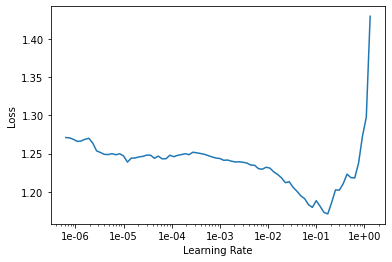

In [12]:
learn.recorder.plot()

In [13]:
%time learn.fit_one_cycle(3, (1e-02+1e-01)/2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.938474,0.902774,0.640273,00:05
1,0.932623,0.924731,0.607509,00:04
2,0.884091,0.882239,0.636860,00:04


CPU times: user 11.4 s, sys: 3.21 s, total: 14.7 s
Wall time: 14.8 s


In [14]:
learn.save("first_try")

In [15]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(((1e-02+1e-01)/4)/(2.6**4),(1e-02+1e-01)/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.888369,0.861611,0.642321,00:05
1,0.829542,0.761981,0.665529,00:05


In [16]:
learn.save('second')

In [17]:
learn.unfreeze()
%time learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.723547,1.205557,0.381570,00:10
1,0.569417,1.286304,0.812287,00:11
2,0.455544,0.460524,0.819795,00:11


CPU times: user 23 s, sys: 9.4 s, total: 32.4 s
Wall time: 33.6 s


In [18]:
learn.save('third')

In [22]:
learn.predict('awesome')

(Category tensor(2), tensor(2), tensor([0.0031, 0.0357, 0.9612]))

## Test on S3 data

In [26]:
df = pd.read_csv(path/'trump.csv') ; df.head(5)

,Unnamed: 0,s
0,0,RT @johncardillo: Trump should get one for the...
1,1,@RL9631 @MarthaMcSally @AZRed65 @AZKAYTE @Heyw...
2,2,@PressSec @realDonaldTrump I can’t wait to vot...
3,3,RT @mimmymum: Judge orders Trump administratio...
4,4,"RT @RealJamesWoods: As a law professor, please..."


In [32]:
df.columns

Index(['Unnamed: 0', 's'], dtype='object')

In [33]:
df_sample = df.head(20)

In [34]:
predictions = [learn.predict(i) for i in df_sample.s]

In [36]:
predictions_df = pd.DataFrame(predictions)

In [37]:
predictions_df

,0,1,2
0,neutral,tensor(1),"[tensor(0.2922), tensor(0.6649), tensor(0.0429)]"
1,neutral,tensor(1),"[tensor(0.0678), tensor(0.8757), tensor(0.0564)]"
2,negative,tensor(0),"[tensor(0.5616), tensor(0.3954), tensor(0.0430)]"
3,neutral,tensor(1),"[tensor(0.0799), tensor(0.8658), tensor(0.0543)]"
4,neutral,tensor(1),"[tensor(0.1033), tensor(0.7590), tensor(0.1378)]"
5,neutral,tensor(1),"[tensor(0.1891), tensor(0.8030), tensor(0.0079)]"
6,neutral,tensor(1),"[tensor(0.0584), tensor(0.9117), tensor(0.0299)]"
7,negative,tensor(0),"[tensor(0.6586), tensor(0.1558), tensor(0.1856)]"
8,neutral,tensor(1),"[tensor(0.0758), tensor(0.7497), tensor(0.1746)]"
9,neutral,tensor(1),"[tensor(0.0452), tensor(0.6724), tensor(0.2824)]"


In [43]:
learn.export('/content/drive/My Drive/model.pkl')